# Scribe 5: Distilling Gaussian Process Knowledge into Neural Networks

**Problem Statement:** A Gaussian Process learns both predictions and uncertainty from data. When we distill it into a neural network, what information gets preserved, what gets lost, and how does uncertainty-weighting affect this transfer?

## Setup
- **Task:** 1D regression with sparse training data
- **Teacher:** Gaussian Process (RBF kernel)
- **Student:** Small neural network
- **Goal:** Explore knowledge distillation by distilling information from a gaussian process model as teacher. While this is an exploratory scribe, scribe 6,7 would dive further deep into the information theoretic persepctive of gaussian processes and knowledge distillation. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 10

## 1. Generate Data

Create a 1D regression problem with sparse training data:
- True function: `f(x) = sin(2πx) + 0.5*sin(4πx)`
- Sparse training points (only 15 points)
- Dense test points for evaluation

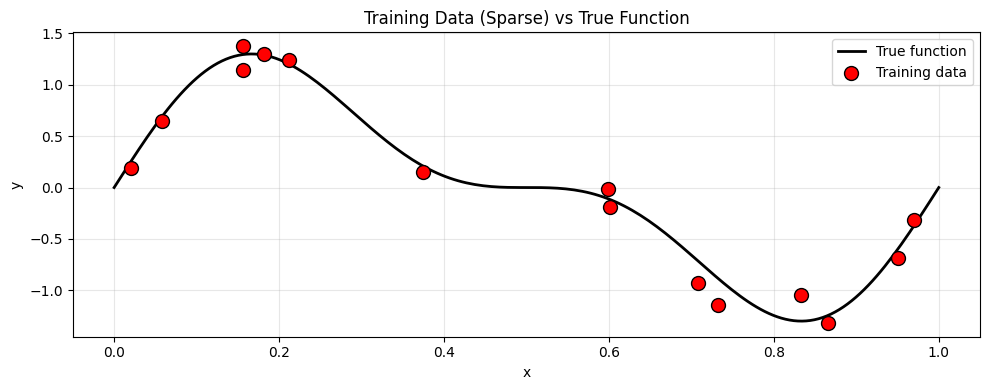

Training points: 15
Test points: 200
Distillation points: 500


In [3]:
def true_function(x):
    """Ground truth function"""
    return np.sin(2 * np.pi * x) + 0.5 * np.sin(4 * np.pi * x)

# Training data (sparse)
n_train = 15
X_train = np.random.uniform(0, 1, n_train).reshape(-1, 1)
y_train = true_function(X_train).ravel() + np.random.normal(0, 0.1, n_train)

# Test data (dense)
X_test = np.linspace(0, 1, 200).reshape(-1, 1)
y_test = true_function(X_test).ravel()

# Distillation data (where we'll query the GP teacher)
n_distill = 500
X_distill = np.linspace(0, 1, n_distill).reshape(-1, 1)

# Visualize data
plt.figure(figsize=(10, 4))
plt.plot(X_test, y_test, 'k-', label='True function', linewidth=2)
plt.scatter(X_train, y_train, c='red', s=100, marker='o', edgecolors='black', label='Training data', zorder=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Data (Sparse) vs True Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Training points: {n_train}")
print(f"Test points: {len(X_test)}")
print(f"Distillation points: {n_distill}")

## 2. Training GP Teacher

Train a Gaussian Process on the sparse training data. The GP will provide:
- **Mean predictions** μ(x): Best estimate at each point
- **Variance** σ²(x): Uncertainty at each point

Trained GP kernel:
0.779**2 * RBF(length_scale=0.143) + WhiteKernel(noise_level=0.0203)


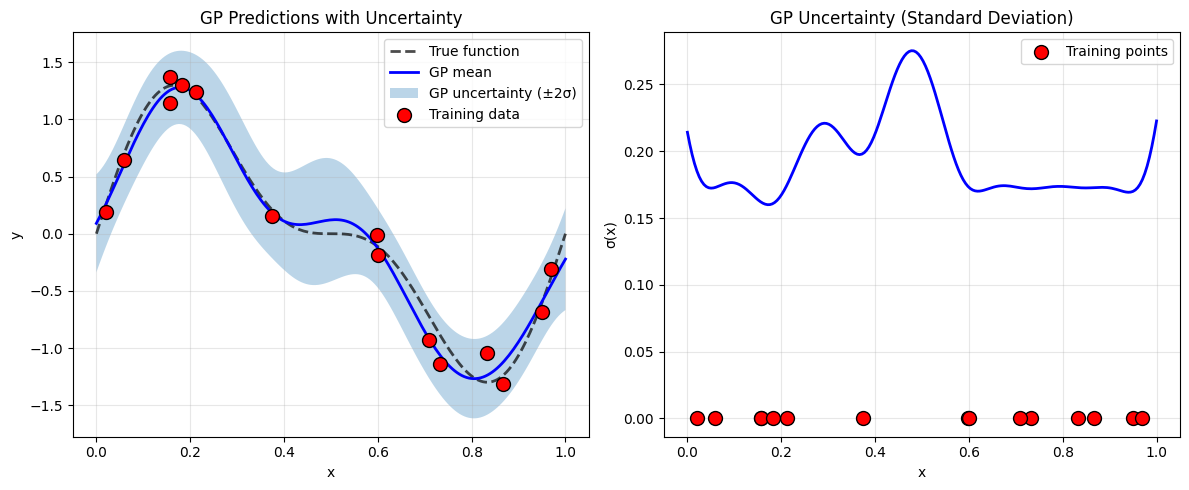


GP Test MSE: 0.008569


In [4]:
# Define kernel: RBF + noise
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.1, length_scale_bounds=(1e-2, 1e1)) + WhiteKernel(noise_level=0.1)

# Train GP
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_train, y_train)

print("Trained GP kernel:")
print(gp.kernel_)

# Get GP predictions on test and distillation sets
y_gp_test, sigma_gp_test = gp.predict(X_test, return_std=True)
y_gp_distill, sigma_gp_distill = gp.predict(X_distill, return_std=True)

# Visualize GP predictions with uncertainty
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(X_test, y_test, 'k--', label='True function', linewidth=2, alpha=0.7)
plt.plot(X_test, y_gp_test, 'b-', label='GP mean', linewidth=2)
plt.fill_between(X_test.ravel(), 
                 y_gp_test - 2*sigma_gp_test, 
                 y_gp_test + 2*sigma_gp_test, 
                 alpha=0.3, label='GP uncertainty (±2σ)')
plt.scatter(X_train, y_train, c='red', s=100, marker='o', edgecolors='black', label='Training data', zorder=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('GP Predictions with Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(X_test, sigma_gp_test, 'b-', linewidth=2)
plt.scatter(X_train, np.zeros_like(y_train), c='red', s=100, marker='o', edgecolors='black', label='Training points', zorder=5)
plt.xlabel('x')
plt.ylabel('σ(x)')
plt.title('GP Uncertainty (Standard Deviation)')
plt.legend()
plt.grid(True, alpha=0.3)
#as we can see that the region where we didn't have any training points -- we had high std deviation

plt.tight_layout()
plt.show()

# Compute GP test error
gp_mse = np.mean((y_gp_test - y_test)**2)
print(f"\nGP Test MSE: {gp_mse:.6f}")

## 3. Defining the Student Network

Simple feedforward neural network with 2 hidden layers.

In [5]:
class StudentNetwork(nn.Module):
    def __init__(self, hidden_sizes=[32, 32]):
        super(StudentNetwork, self).__init__()
        layers = []
        input_size = 1
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        
        layers.append(nn.Linear(input_size, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Test instantiation
test_student = StudentNetwork()
print("Student Network Architecture:")
print(test_student)
print(f"\nTotal parameters: {sum(p.numel() for p in test_student.parameters())}")

Student Network Architecture:
StudentNetwork(
  (network): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 1153


## 4. Training Function

Generic training function that we'll use for different scenarios.

In [6]:
def train_student(model, X, y, weights=None, epochs=1000, lr=0.01, verbose=True, use_scheduler=True):
    """
    Train student network.
    
    Args:
        model: Student network
        X: Input data
        y: Target data
        weights: Optional weights for each sample (for uncertainty-weighted loss)
        epochs: Number of training epochs
        lr: Learning rate
        verbose: Print training progress
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    if use_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=500, verbose=False)
    
    # Convert to tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y).reshape(-1, 1)
    
    if weights is not None:
        weights_tensor = torch.FloatTensor(weights).reshape(-1, 1)
    
    losses = []
    lrs = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(X_tensor)
        
        # Compute loss
        if weights is not None:
            # Weighted MSE loss
            loss = torch.mean(weights_tensor * (y_pred - y_tensor)**2)
        else:
            # Standard MSE loss
            loss = nn.MSELoss()(y_pred, y_tensor)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        # Update scheduler
        if use_scheduler:
            scheduler.step(loss)
            lrs.append(optimizer.param_groups[0]['lr'])

        losses.append(loss.item())
        
        if verbose and (epoch + 1) % 200 == 0:
            current_lr = optimizer.param_groups[0]['lr'] if use_scheduler else lr
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}, LR: {current_lr:.6f}")
    
    return losses, lrs if use_scheduler else []

def evaluate_student(model, X, y):
    """Evaluate student network."""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X)
        y_pred = model(X_tensor).numpy().ravel()
    model.train() # restores the model to train mode and disables the eval mode (a good practice even though we aren't training it further)
    
    mse = np.mean((y_pred - y)**2)
    return y_pred, mse

## 5. Experiment 1: Train Student Directly on Data

**Baseline:** Train student on the same sparse training data the GP saw.

In [7]:
print("=== Experiment 1: Student trained directly on data ===")

student_direct = StudentNetwork(hidden_sizes=[32, 32])
losses_direct, lrs_direct = train_student(student_direct, X_train, y_train, epochs=5000, lr=0.01)

# Evaluate
y_direct_test, mse_direct = evaluate_student(student_direct, X_test, y_test)
print(f"\nStudent (Direct) Test MSE: {mse_direct:.6f}")
print(f"GP Test MSE: {gp_mse:.6f}")
print(f"MSE Ratio (Student/GP): {mse_direct/gp_mse:.2f}x")

=== Experiment 1: Student trained directly on data ===
Epoch 200/5000, Loss: 0.041336, LR: 0.010000
Epoch 400/5000, Loss: 0.036467, LR: 0.010000
Epoch 600/5000, Loss: 0.037093, LR: 0.010000
Epoch 800/5000, Loss: 0.032728, LR: 0.010000
Epoch 1000/5000, Loss: 0.031811, LR: 0.010000
Epoch 1200/5000, Loss: 0.038312, LR: 0.010000
Epoch 1400/5000, Loss: 0.029872, LR: 0.010000
Epoch 1600/5000, Loss: 0.029657, LR: 0.010000
Epoch 1800/5000, Loss: 0.029622, LR: 0.010000
Epoch 2000/5000, Loss: 0.029837, LR: 0.010000
Epoch 2200/5000, Loss: 0.031117, LR: 0.010000
Epoch 2400/5000, Loss: 0.029114, LR: 0.010000
Epoch 2600/5000, Loss: 0.029128, LR: 0.010000
Epoch 2800/5000, Loss: 0.028870, LR: 0.010000
Epoch 3000/5000, Loss: 0.028797, LR: 0.010000
Epoch 3200/5000, Loss: 0.038746, LR: 0.010000
Epoch 3400/5000, Loss: 0.028687, LR: 0.010000
Epoch 3600/5000, Loss: 0.029409, LR: 0.010000
Epoch 3800/5000, Loss: 0.030193, LR: 0.010000
Epoch 4000/5000, Loss: 0.028952, LR: 0.010000
Epoch 4200/5000, Loss: 0.0287

## 6. Experiment 2: Distill from GP (Uniform Weighting)

Train student to match GP's predictions on a dense grid, but treat all points equally.

In [8]:
print("\n=== Experiment 2: Student distilled from GP (uniform weighting) ===")

student_distill_uniform = StudentNetwork(hidden_sizes=[32, 32])
losses_distill_uniform, lrs_distill_uniform = train_student(
    student_distill_uniform, 
    X_distill, 
    y_gp_distill, 
    weights=None,  # No weighting
    epochs=5000, 
    lr=0.01
)

# Evaluate
y_distill_uniform_test, mse_distill_uniform = evaluate_student(student_distill_uniform, X_test, y_test)
print(f"\nStudent (Distill Uniform) Test MSE: {mse_distill_uniform:.6f}")
print(f"GP Test MSE: {gp_mse:.6f}")
print(f"MSE Ratio (Student/GP): {mse_distill_uniform/gp_mse:.2f}x")


=== Experiment 2: Student distilled from GP (uniform weighting) ===
Epoch 200/5000, Loss: 0.022957, LR: 0.010000
Epoch 400/5000, Loss: 0.001047, LR: 0.010000
Epoch 600/5000, Loss: 0.000273, LR: 0.010000
Epoch 800/5000, Loss: 0.000172, LR: 0.010000
Epoch 1000/5000, Loss: 0.000151, LR: 0.010000
Epoch 1200/5000, Loss: 0.000134, LR: 0.010000
Epoch 1400/5000, Loss: 0.000155, LR: 0.010000
Epoch 1600/5000, Loss: 0.000132, LR: 0.010000
Epoch 1800/5000, Loss: 0.000139, LR: 0.010000
Epoch 2000/5000, Loss: 0.000133, LR: 0.010000
Epoch 2200/5000, Loss: 0.000119, LR: 0.010000
Epoch 2400/5000, Loss: 0.000125, LR: 0.010000
Epoch 2600/5000, Loss: 0.001844, LR: 0.010000
Epoch 2800/5000, Loss: 0.000117, LR: 0.010000
Epoch 3000/5000, Loss: 0.000112, LR: 0.010000
Epoch 3200/5000, Loss: 0.000136, LR: 0.010000
Epoch 3400/5000, Loss: 0.000109, LR: 0.010000
Epoch 3600/5000, Loss: 0.000120, LR: 0.010000
Epoch 3800/5000, Loss: 0.000112, LR: 0.010000
Epoch 4000/5000, Loss: 0.000109, LR: 0.010000
Epoch 4200/5000

## 7. Experiment 3: Distill from GP (Uncertainty-Weighted)

**Key idea:** Weight the loss by GP's confidence (inverse variance).
- High confidence regions (near training data) → high weight
- Low confidence regions (far from data) → low weight

Loss: `L = Σ (1/σ²(x)) * (y_student(x) - μ_GP(x))²`

In [9]:
print("\n=== Experiment 3: Student distilled from GP (uncertainty-weighted) ===")

# Compute weights: inverse variance (higher confidence = higher weight)
weights_uncertainty = 1.0 / (sigma_gp_distill**2 + 1e-6)  # Add small epsilon for numerical stability

# Normalize weights to have mean 1 (optional, for fair comparison)
weights_uncertainty = weights_uncertainty / weights_uncertainty.mean()

print(f"Weight statistics:")
print(f"  Min weight: {weights_uncertainty.min():.2f}")
print(f"  Max weight: {weights_uncertainty.max():.2f}")
print(f"  Mean weight: {weights_uncertainty.mean():.2f}")

student_distill_weighted = StudentNetwork(hidden_sizes=[32, 32])
losses_distill_weighted, lrs_distill_weighted = train_student(
    student_distill_weighted, 
    X_distill, 
    y_gp_distill, 
    weights=weights_uncertainty,
    epochs=5000, 
    lr=0.01
)

# Evaluate
y_distill_weighted_test, mse_distill_weighted = evaluate_student(student_distill_weighted, X_test, y_test)
print(f"\nStudent (Distill Weighted) Test MSE: {mse_distill_weighted:.6f}")
print(f"GP Test MSE: {gp_mse:.6f}")
print(f"MSE Ratio (Student/GP): {mse_distill_weighted/gp_mse:.2f}x")


=== Experiment 3: Student distilled from GP (uncertainty-weighted) ===
Weight statistics:
  Min weight: 0.46
  Max weight: 1.36
  Mean weight: 1.00
Epoch 200/5000, Loss: 0.025841, LR: 0.010000
Epoch 400/5000, Loss: 0.027131, LR: 0.010000
Epoch 600/5000, Loss: 0.018466, LR: 0.010000
Epoch 800/5000, Loss: 0.018413, LR: 0.010000
Epoch 1000/5000, Loss: 0.018401, LR: 0.010000
Epoch 1200/5000, Loss: 0.018403, LR: 0.010000
Epoch 1400/5000, Loss: 0.018421, LR: 0.010000
Epoch 1600/5000, Loss: 0.018388, LR: 0.010000
Epoch 1800/5000, Loss: 0.018396, LR: 0.010000
Epoch 2000/5000, Loss: 0.018411, LR: 0.010000
Epoch 2200/5000, Loss: 0.018387, LR: 0.007500
Epoch 2400/5000, Loss: 0.018383, LR: 0.007500
Epoch 2600/5000, Loss: 0.018382, LR: 0.007500
Epoch 2800/5000, Loss: 0.018384, LR: 0.007500
Epoch 3000/5000, Loss: 0.018382, LR: 0.005625
Epoch 3200/5000, Loss: 0.018381, LR: 0.005625
Epoch 3400/5000, Loss: 0.018381, LR: 0.005625
Epoch 3600/5000, Loss: 0.018382, LR: 0.005625
Epoch 3800/5000, Loss: 0.01

## 8. Compare All Methods

Visualize predictions from all three training approaches.

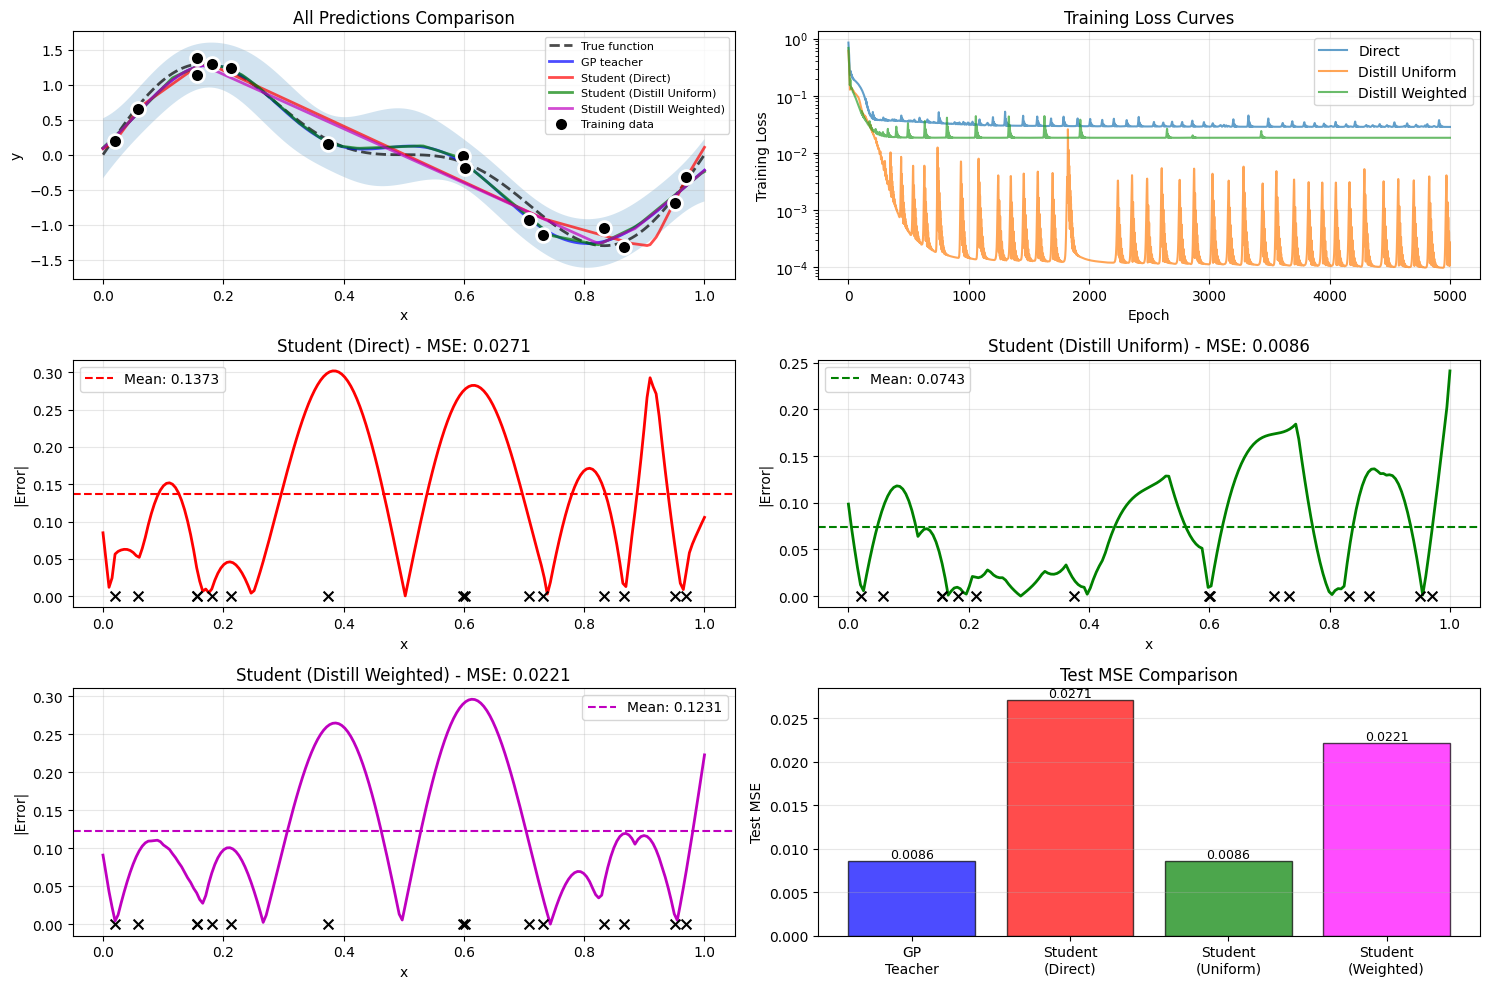


SUMMARY
GP Teacher MSE:              0.008569
Student (Direct) MSE:        0.027125  (3.17x worse than GP)
Student (Distill Uniform):   0.008600  (1.00x worse than GP)
Student (Distill Weighted):  0.022124  (2.58x worse than GP)


In [10]:
plt.figure(figsize=(15, 10))

# Plot 1: All predictions
plt.subplot(3, 2, 1)
plt.plot(X_test, y_test, 'k--', label='True function', linewidth=2, alpha=0.7)
plt.plot(X_test, y_gp_test, 'b-', label='GP teacher', linewidth=2, alpha=0.7)
plt.fill_between(X_test.ravel(), y_gp_test - 2*sigma_gp_test, y_gp_test + 2*sigma_gp_test, alpha=0.2)
plt.plot(X_test, y_direct_test, 'r-', label='Student (Direct)', linewidth=2, alpha=0.7)
plt.plot(X_test, y_distill_uniform_test, 'g-', label='Student (Distill Uniform)', linewidth=2, alpha=0.7)
plt.plot(X_test, y_distill_weighted_test, 'm-', label='Student (Distill Weighted)', linewidth=2, alpha=0.7)
plt.scatter(X_train, y_train, c='black', s=100, marker='o', edgecolors='white', linewidths=2, label='Training data', zorder=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('All Predictions Comparison')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True, alpha=0.3)

# Plot 2: Training loss curves
plt.subplot(3, 2, 2)
plt.plot(losses_direct, label='Direct', alpha=0.7)
plt.plot(losses_distill_uniform, label='Distill Uniform', alpha=0.7)
plt.plot(losses_distill_weighted, label='Distill Weighted', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 3: Student (Direct) error
plt.subplot(3, 2, 3)
error_direct = np.abs(y_direct_test - y_test)
plt.plot(X_test, error_direct, 'r-', linewidth=2)
plt.axhline(y=np.mean(error_direct), color='r', linestyle='--', label=f'Mean: {np.mean(error_direct):.4f}')
plt.scatter(X_train, np.zeros_like(y_train), c='black', s=50, marker='x', zorder=5)
plt.xlabel('x')
plt.ylabel('|Error|')
plt.title(f'Student (Direct) - MSE: {mse_direct:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Student (Distill Uniform) error
plt.subplot(3, 2, 4)
error_uniform = np.abs(y_distill_uniform_test - y_test)
plt.plot(X_test, error_uniform, 'g-', linewidth=2)
plt.axhline(y=np.mean(error_uniform), color='g', linestyle='--', label=f'Mean: {np.mean(error_uniform):.4f}')
plt.scatter(X_train, np.zeros_like(y_train), c='black', s=50, marker='x', zorder=5)
plt.xlabel('x')
plt.ylabel('|Error|')
plt.title(f'Student (Distill Uniform) - MSE: {mse_distill_uniform:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Student (Distill Weighted) error
plt.subplot(3, 2, 5)
error_weighted = np.abs(y_distill_weighted_test - y_test)
plt.plot(X_test, error_weighted, 'm-', linewidth=2)
plt.axhline(y=np.mean(error_weighted), color='m', linestyle='--', label=f'Mean: {np.mean(error_weighted):.4f}')
plt.scatter(X_train, np.zeros_like(y_train), c='black', s=50, marker='x', zorder=5)
plt.xlabel('x')
plt.ylabel('|Error|')
plt.title(f'Student (Distill Weighted) - MSE: {mse_distill_weighted:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: MSE comparison bar chart
plt.subplot(3, 2, 6)
methods = ['GP\nTeacher', 'Student\n(Direct)', 'Student\n(Uniform)', 'Student\n(Weighted)']
mses = [gp_mse, mse_direct, mse_distill_uniform, mse_distill_weighted]
colors = ['blue', 'red', 'green', 'magenta']
bars = plt.bar(methods, mses, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Test MSE')
plt.title('Test MSE Comparison')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, mse in zip(bars, mses):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{mse:.4f}',
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"GP Teacher MSE:              {gp_mse:.6f}")
print(f"Student (Direct) MSE:        {mse_direct:.6f}  ({mse_direct/gp_mse:.2f}x worse than GP)")
print(f"Student (Distill Uniform):   {mse_distill_uniform:.6f}  ({mse_distill_uniform/gp_mse:.2f}x worse than GP)")
print(f"Student (Distill Weighted):  {mse_distill_weighted:.6f}  ({mse_distill_weighted/gp_mse:.2f}x worse than GP)")
print("="*50)

## 9. Analysis: What Information Does the Student Learn?

Let's analyze where each student makes the biggest errors relative to the GP.

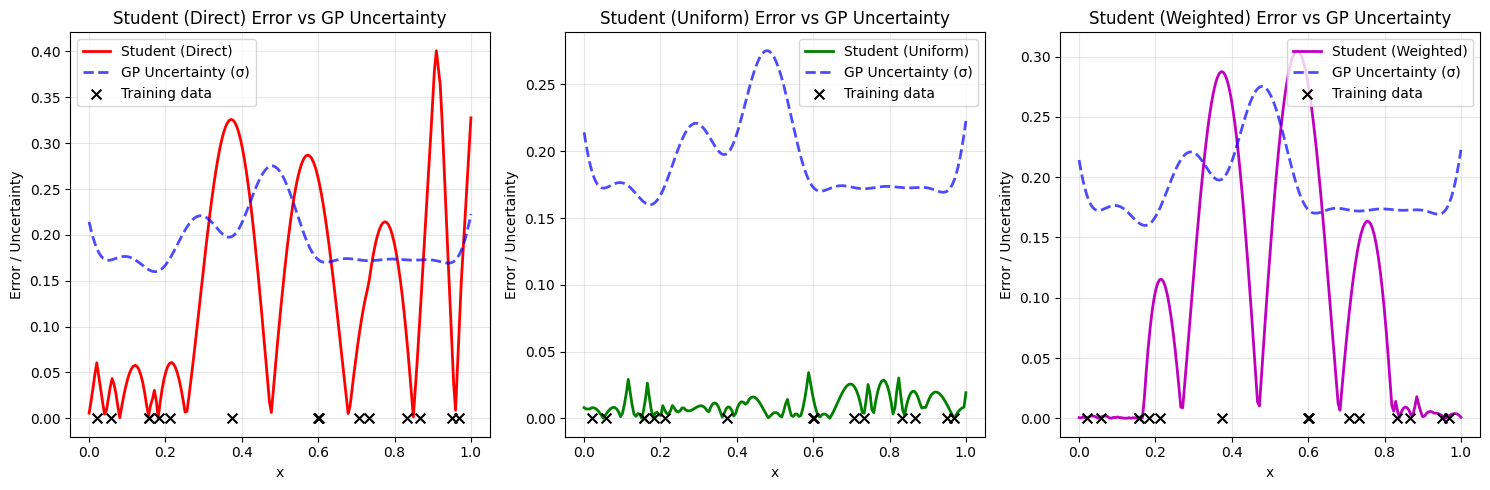


Correlation between GP uncertainty and student error:
Student (Direct):  0.120
Student (Uniform): -0.213
Student (Weighted): 0.276


In [11]:
# Compare predictions to GP (not true function)
error_vs_gp_direct = np.abs(y_direct_test - y_gp_test)
error_vs_gp_uniform = np.abs(y_distill_uniform_test - y_gp_test)
error_vs_gp_weighted = np.abs(y_distill_weighted_test - y_gp_test)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(X_test, error_vs_gp_direct, 'r-', linewidth=2, label='Student (Direct)')
plt.plot(X_test, sigma_gp_test, 'b--', linewidth=2, alpha=0.7, label='GP Uncertainty (σ)')
plt.scatter(X_train, np.zeros_like(y_train), c='black', s=50, marker='x', zorder=5, label='Training data')
plt.xlabel('x')
plt.ylabel('Error / Uncertainty')
plt.title('Student (Direct) Error vs GP Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(X_test, error_vs_gp_uniform, 'g-', linewidth=2, label='Student (Uniform)')
plt.plot(X_test, sigma_gp_test, 'b--', linewidth=2, alpha=0.7, label='GP Uncertainty (σ)')
plt.scatter(X_train, np.zeros_like(y_train), c='black', s=50, marker='x', zorder=5, label='Training data')
plt.xlabel('x')
plt.ylabel('Error / Uncertainty')
plt.title('Student (Uniform) Error vs GP Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(X_test, error_vs_gp_weighted, 'm-', linewidth=2, label='Student (Weighted)')
plt.plot(X_test, sigma_gp_test, 'b--', linewidth=2, alpha=0.7, label='GP Uncertainty (σ)')
plt.scatter(X_train, np.zeros_like(y_train), c='black', s=50, marker='x', zorder=5, label='Training data')
plt.xlabel('x')
plt.ylabel('Error / Uncertainty')
plt.title('Student (Weighted) Error vs GP Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCorrelation between GP uncertainty and student error:")
print(f"Student (Direct):  {np.corrcoef(sigma_gp_test, error_vs_gp_direct)[0,1]:.3f}")
print(f"Student (Uniform): {np.corrcoef(sigma_gp_test, error_vs_gp_uniform)[0,1]:.3f}")
print(f"Student (Weighted): {np.corrcoef(sigma_gp_test, error_vs_gp_weighted)[0,1]:.3f}")

Some comments:

1. **With more data we were able to get better performance:** Distillation on 500 GP predictions gives us a better student performance as compared to training the student just on 15 points.

2. **Uncertainty weighting matters:** By weighting the loss with GP's confidence, the student focuses on learning the high-confidence regions well.

3. **Trade-off in uncertain regions:** Weighted distillation may allow larger errors in uncertain regions. This could be good (don't hallucinate) or bad (lose generalization)
   
4. **With introducing the weighted errors, we have diverted from the original objective of modelling the true function**. Our new objective is to only learn the good things (that the GP teacher is certain about). This reduces the overall performance of our student model. However allows the student to have a positive correlation between the teacher uncertainty and student uncertainty. We can see that the student has large errors where  the GP teacher was itself uncertain. 